# PII Detection - Comparative between two datasets

In [1]:
# %pip install gensim
# %pip install sentence-transformers
# %pip install tensorflow
# %pip install tf-keras
# %pip install wordcloud

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from nltk.corpus import stopwords
import re
from wordcloud import STOPWORDS
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.ensemble import VotingClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity

print("Libraries imported successfully.")


Libraries imported successfully.


## Load dataset
The dataset used in this project 2 datasets PII Detection Dataset (GPT-generated) available on Kaggle and Customer Support Twitter.
### PII Detection Dataset

In [4]:
df = pd.read_csv("ai_data.csv")
# df.info()
# df.head()


This dataset is essentially semi-structured labeled text, where:

The text column (Column 0) gives context, raw sentences.

The dictionary column (column 1) tells you what PII types exist (like NAME_STUDENT, EMAIL, etc.).

In [5]:
df.columns = ['Text', 'PII_types']
# df.head()

In [6]:
df['PII_types'].value_counts()

PII_types
{'NAME_STUDENT': ['Jordan'], 'EMAIL': ['roberto35@gmail.com'], 'USERNAME': ['john75'], 'ID_NUM': ['QFKS39116285013003'], 'PHONE_NUM': ['(933)631-9373'], 'URL_PERSONAL': ['https://linkedin.com/in/laurensullivan', 'https://github.com/michael13', 'https://facebook.com/scabrera'], 'STREET_ADDRESS': ['20939 Buck Gateway, Port Oliviaside, KY 48411', '03325 Eric Underpass Suite 388, Jenniferfurt, MH 38935']}    1
{'NAME_STUDENT': ['Sandra Keller'], 'EMAIL': ['zadams@gmail.com'], 'USERNAME': ['cathy42', 'johnsonjustin'], 'ID_NUM': ['228979061'], 'PHONE_NUM': ['001-388-541-0582'], 'URL_PERSONAL': ['https://github.com/allison15', 'https://facebook.com/justin12'], 'STREET_ADDRESS': ['34637 Paul Gardens, Samuelstad, NH 07805']}                                                                                             1
{'NAME_STUDENT': ['Martin'], 'EMAIL': ['stacygoodwin@hotmail.com'], 'USERNAME': ['davilakaren'], 'ID_NUM': ['583-MPF'], 'PHONE_NUM': ['001-764-790-4323x06557'], 'URL_PERS

In [7]:
df.isnull().sum()
df.duplicated().sum()   


np.int64(0)

#### Convert from PII dictionary to JSON file

In [8]:
type(df['PII_types'].iloc[0])

str

In [9]:
df['PII_types'] = df['PII_types'].apply(lambda x: json.loads(x.replace("'", '"')))
# df.head()

In [10]:
df['has_PII'] = df['PII_types'].apply(lambda x: any(len(v) > 0 for v in x.values()))
# df.head()

In [11]:
df["has_PII"].value_counts()

has_PII
True     1999
False       1
Name: count, dtype: int64

#### Implement columns clean_text and clean_text_light

In [12]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()                    # lowercase all words
    text = re.sub(r'[^a-z\s]', '', text)        # remove punctuation, numbers, special chars
    words = [w for w in text.split() if w not in stop]  #remove stopwords
    return " ".join(words) 

def clean_text_light(text):
    return str(text).lower()                    
df['clean_text'] = df['Text'].apply(clean_text)
df['clean_text_light'] = df['Text'].apply(clean_text_light)
df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Text,PII_types,has_PII,clean_text,clean_text_light
0,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Richard', 'Chang'], 'EMAIL'...",True,todays modern world technology become integral...,"in today's modern world, where technology has ..."
1,"In today's modern world, where technology has ...","{'NAME_STUDENT': [], 'EMAIL': ['tamaramorrison...",True,todays modern world technology become integral...,"in today's modern world, where technology has ..."
2,Janice: A Student with a Unique Identity\n\nIn...,"{'NAME_STUDENT': ['Janice'], 'EMAIL': ['laura5...",True,janice student unique identity todays fastpace...,janice: a student with a unique identity\n\nin...
3,Christian is a student who goes by the usernam...,"{'NAME_STUDENT': ['Christian'], 'EMAIL': [], '...",True,christian student goes username stephensdennis...,christian is a student who goes by the usernam...
4,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Aaron Smith', 'Fischer', 'T...",True,todays modern world technology become integral...,"in today's modern world, where technology has ..."


### Customer Support Twitter Dataset

In [13]:
df_cs = pd.read_csv("customer_support.csv")
df_cs["text"] = df_cs["input"].fillna('') + " " + df_cs["output"].fillna('')
# df_cs.head()

In [14]:
pii_patterns = [
    r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}',      # emails
    r'\b\+?\d[\d\s\-]{6,}\b',                               # phone-like numbers
    r'\b\d{4}[-\s]?\d{4}[-\s]?\d{4}[-\s]?\d{4}\b',          # credit card pattern
    r'\b[A-Z0-9]{8,}\b',                                    # IDs like Q32004774643
]

def detect_pii(text):
    text = str(text)
    return int(any(re.search(p, text) for p in pii_patterns))

df_cs["has_PII"] = df_cs["text"].apply(detect_pii)

print(df_cs["has_PII"].value_counts())
df_cs.head()


has_PII
0    905897
1     39381
Name: count, dtype: int64


,output,input,text,has_PII
0,I would love the chance to review the account ...,is the worst customer service,is the worst customer service I would love the...,0
1,H there! we would definitely like to work with...,y’all lie about your “great” connection. 5 bar...,y’all lie about your “great” connection. 5 bar...,0
2,We understand your concerns and we would like ...,Since I signed up with you....Since day 1,Since I signed up with you....Since day 1 We u...,0
3,This is saddening to hear. Please shoot us a D...,You gonna magically change your connectivity f...,You gonna magically change your connectivity f...,0
4,Please send me a private message so that I can...,"whenever I contact customer support, they tell...","whenever I contact customer support, they tell...",0


## 2. Data & Model Visualization

In [42]:
df.head()

,Text,PII_types,has_PII,clean_text,clean_text_light,text_length,word_count
0,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Richard', 'Chang'], 'EMAIL'...",True,todays modern world technology become integral...,"in today's modern world, where technology has ...",2484,358
1,"In today's modern world, where technology has ...","{'NAME_STUDENT': [], 'EMAIL': ['tamaramorrison...",True,todays modern world technology become integral...,"in today's modern world, where technology has ...",2906,425
2,Janice: A Student with a Unique Identity\n\nIn...,"{'NAME_STUDENT': ['Janice'], 'EMAIL': ['laura5...",True,janice student unique identity todays fastpace...,janice: a student with a unique identity\n\nin...,2762,413
3,Christian is a student who goes by the usernam...,"{'NAME_STUDENT': ['Christian'], 'EMAIL': [], '...",True,christian student goes username stephensdennis...,christian is a student who goes by the usernam...,1380,206
4,"In today's modern world, where technology has ...","{'NAME_STUDENT': ['Aaron Smith', 'Fischer', 'T...",True,todays modern world technology become integral...,"in today's modern world, where technology has ...",2418,357


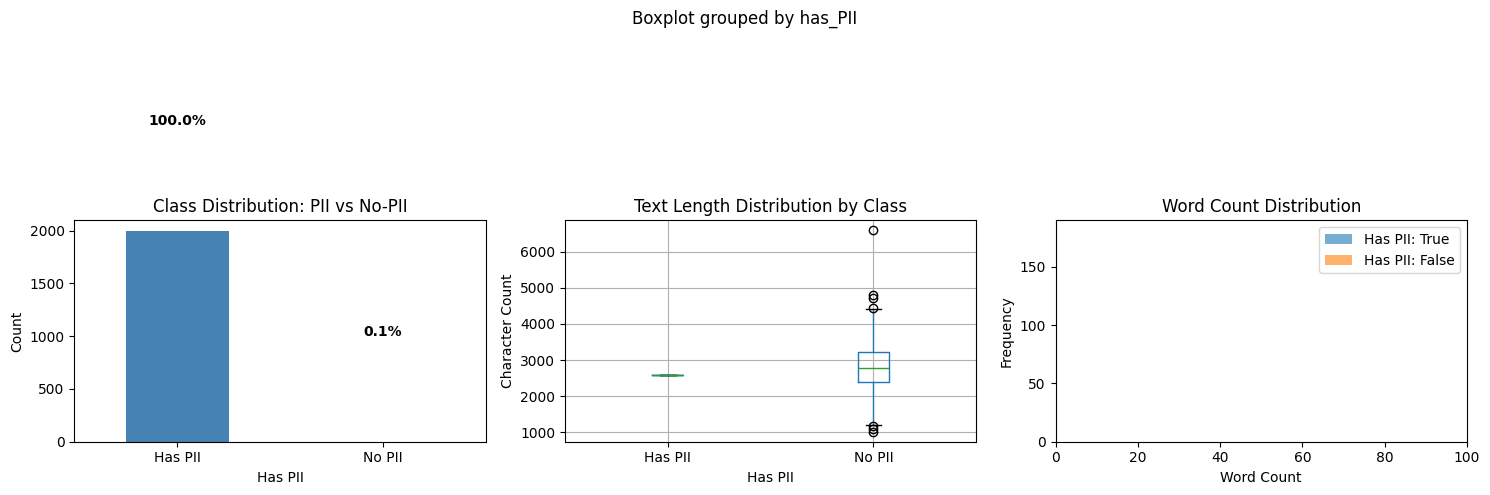

In [49]:
# Class distribution
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Class balance
df['has_PII'].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Class Distribution: PII vs No-PII')
axes[0].set_xlabel('Has PII')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Has PII', 'No PII'], rotation=0)


# Add percentage annotations
total = len(df)
for i, v in enumerate(df['has_PII'].value_counts()):
    axes[0].text(i, v + 1000, f'{v/total*100:.1f}%', ha='center', fontweight='bold')

# 2. Text length distribution
df['text_length'] = df['Text'].str.len()
df.boxplot(column='text_length', by='has_PII', ax=axes[1])
axes[1].set_title('Text Length Distribution by Class')
axes[1].set_xlabel('Has PII')
axes[1].set_ylabel('Character Count')
plt.sca(axes[1])
plt.xticks([1, 2], ['Has PII', 'No PII'])

# 3. Word count distribution
df['word_count'] = df['Text'].str.split().str.len()
for label in [True, False]:
    subset = df[df['has_PII'] == label]['word_count']
    axes[2].hist(subset, bins=50, alpha=0.6, label=f'Has PII: {label}')
axes[2].set_title('Word Count Distribution')
axes[2].set_xlabel('Word Count')
axes[2].set_ylabel('Frequency')
axes[2].legend()
axes[2].set_xlim(0, 100)  

plt.tight_layout()
plt.show()


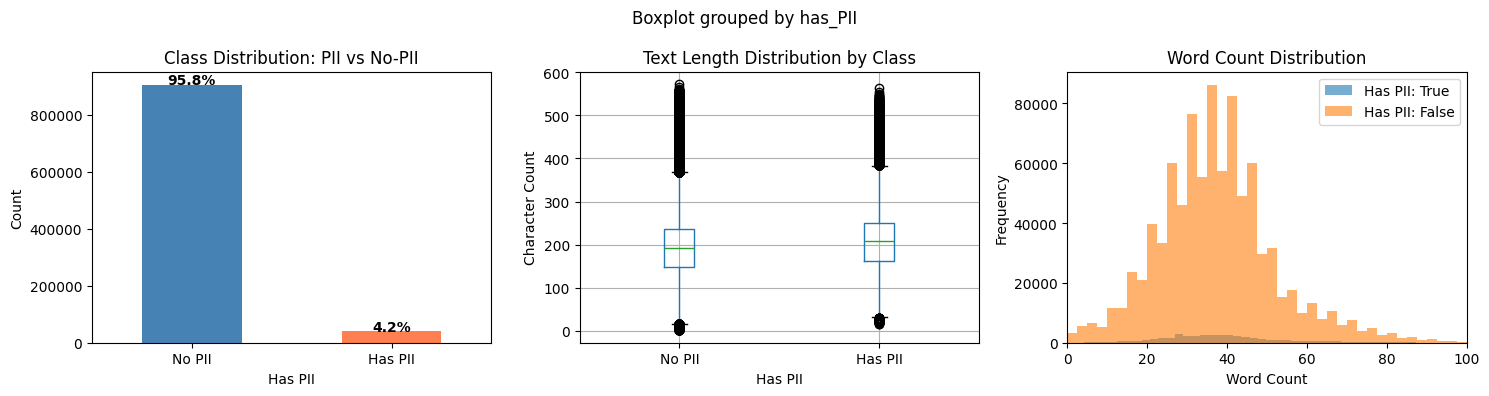

In [51]:
# Class distribution
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Class balance
df_cs['has_PII'].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Class Distribution: PII vs No-PII')
axes[0].set_xlabel('Has PII')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No PII', 'Has PII'], rotation=0)

# Add percentage annotations
total = len(df_cs)
for i, v in enumerate(df_cs['has_PII'].value_counts()):
    axes[0].text(i, v + 1000, f'{v/total*100:.1f}%', ha='center', fontweight='bold')

# 2. Text length distribution
df_cs['text_length'] = df_cs['text'].str.len()
df_cs.boxplot(column='text_length', by='has_PII', ax=axes[1])
axes[1].set_title('Text Length Distribution by Class')
axes[1].set_xlabel('Has PII')
axes[1].set_ylabel('Character Count')
plt.sca(axes[1])
plt.xticks([1, 2], ['No PII', 'Has PII'])

# 3. Word count distribution
df_cs['word_count'] = df_cs['text'].str.split().str.len()
for label in [True, False]:
    subset = df_cs[df_cs['has_PII'] == label]['word_count']
    axes[2].hist(subset, bins=50, alpha=0.6, label=f'Has PII: {label}')
axes[2].set_title('Word Count Distribution')
axes[2].set_xlabel('Word Count')
axes[2].set_ylabel('Frequency')
axes[2].legend()
axes[2].set_xlim(0, 100)
plt.tight_layout()
plt.show()


### Embeddings
I define these embeddings (TF-IDF, Word2Vec, BERT)

In [16]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(df['clean_text'])
# tfidf_df.sum().sort_values(ascending=False).head(20)

In [17]:
sentences = [text.split() for text in df['clean_text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)
def get_sentence_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)
X_w2v = np.array([get_sentence_vector(text, w2v_model) for text in df['clean_text']])   


In [18]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = bert_model.encode(df['clean_text'].tolist())
X_bert = bert_model.encode(df['clean_text'].tolist(), show_progress_bar=True)



Batches:   0%|          | 0/63 [00:00<?, ?it/s]

## Modelling
Dataset A (PII Detection) = “lab environment” where the model learns what PII looks like.

Dataset B (Customer Support Twitter) = “real world” where I can check if the model can still recognize PII in messy, conversational text.

### Machine Learning Models
These models work well with TF-IDF features. The goal aims to show foundational models
| Model | Key Hyperparameters| When to Use | Notes  |
| ------ | -------| -------------------- | ------------ |
| **Logistic Regression**          | `C`, `penalty`, `solver`                     | Baseline classifier for text; works well with sparse vectors   | Great interpretability (weights show top PII words) |
| **Support Vector Machine (SVM)** | `C`, `kernel` (`linear`, `rbf`)              | When you expect clear separability                             | Often high accuracy for text                        |
| **Naïve Bayes (MultinomialNB)**  | `alpha` (smoothing)                          | Text data with word counts                                     | Very fast and strong baseline                       |
| **Random Forest**                | `n_estimators`, `max_depth`                  | Non-linear model; works with dense features (e.g., embeddings) | Can overfit small datasets                          |
| **K-Nearest Neighbors (KNN)**    | `n_neighbors`                                | Rarely best for text, but good for comparison                  | Works better on small feature sets                  |


### Deep Learning Models 
These deep learning models work well on Word2Vec. The goal aims to learn sequential/contextual structure.
| Model   | Type | Notes           |
| ----- | ---------- | --------------------|
| **Feed-Forward Neural Network (FFNN)**          | Baseline DNN (dense layers)                    | Works on averaged embeddings                                |
| **Convolutional Neural Network (CNN)** for text | Uses 1D conv layers on embeddings              | Detects local n-gram patterns like “call me on”, “email is” |
| **LSTM (Long Short-Term Memory)**               | RNN type                                       | Captures long-term dependencies in sentences                |


In [19]:
# PII Detection Dataset
X_pii = df["Text"].astype(str)
y_pii = df["has_PII"].astype(int)

X_train_pii, X_test_pii, y_train_pii, y_test_pii = train_test_split(
    X_pii, y_pii, test_size=0.2, random_state=42
)

print("Train size:", X_train_pii.shape[0])
print("Test size:", X_test_pii.shape[0])


Train size: 1600
Test size: 400


Combined embedding shape: (2000, 5484)
Logistic Regression
              precision    recall  f1-score   support

        True       1.00      1.00      1.00       400

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

Random Forest
              precision    recall  f1-score   support

        True       1.00      1.00      1.00       400

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

SVM
              precision    recall  f1-score   support

        True       1.00      1.00      1.00       400

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

Logistic Regression
              precision    recall  f1-score   support

        True       1.00      

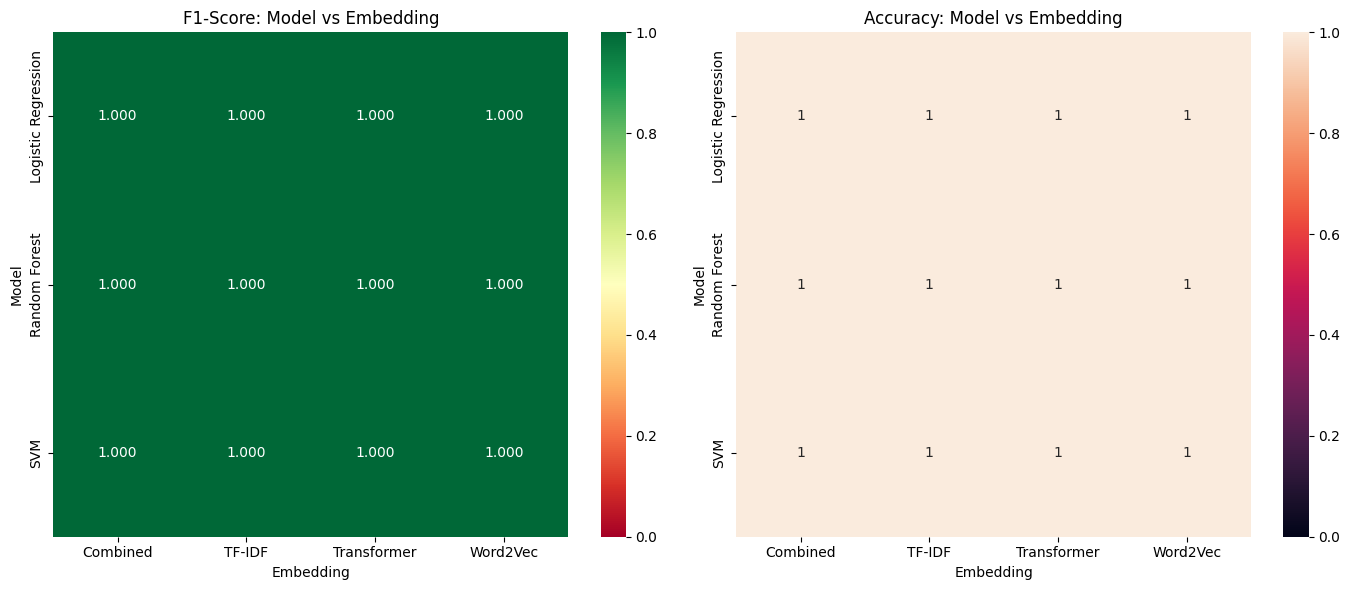

In [20]:
y = df['has_PII']

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)
X_train_bert, X_test_bert, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42)

X_combined = np.hstack([X_tfidf.toarray(), X_w2v, X_bert])
X_train_comb, X_test_comb, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)
print(f"Combined embedding shape: {X_combined.shape}")
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42)
}

results = []

embeddings_train_test = {
    'TF-IDF': (X_train_tfidf, X_test_tfidf),
    'Word2Vec': (X_train_w2v, X_test_w2v),
    'Transformer': (X_train_bert, X_test_bert),
    'Combined': (X_train_comb, X_test_comb), 
}

for emb_name, (X_train, X_test) in embeddings_train_test.items():
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        results.append ({
            'Embedding': emb_name,
            'Model': model_name,
            'Accuracy': report['accuracy'],
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score']
        })

        print(model_name)
        print(classification_report(y_test, y_pred))
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

#Visualize results
plt.figure(figsize=(14, 6))

# F1-Score comparison
pivot_f1 = results_df.pivot(index='Model', columns='Embedding', values='F1-Score')
plt.subplot(1, 2, 1)
sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1)
plt.title('F1-Score: Model vs Embedding')

# Accuracy comparison
pivot_acc = results_df.pivot(index='Model', columns='Embedding', values='Accuracy')
plt.subplot(1, 2, 2)
sns.heatmap(pivot_acc, annot=True, vmin=0, vmax=1)
plt.title('Accuracy: Model vs Embedding')

plt.tight_layout()
plt.show()


In [54]:
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"[^a-z0-9@\s\-\.]", " ", s)  # keep digits, @, dots, dashes
    words = [w for w in s.split() if w not in stop]
    return " ".join(words)

df_cs["clean_text"] = df_cs["text"].apply(clean_text)
# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_cs_tfidf = tfidf.fit_transform(df_cs["clean_text"])
# Word2Vec
tokens = df_cs["clean_text"].apply(str.split).tolist()

w2v_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=5, sg=1)

def sent_vec_w2v(words):
    vecs = [w2v_model.wv[w] for w in words if w in w2v_model.wv]
    if not vecs:
        return np.zeros(100)
    return np.mean(vecs, axis=0)

X_cs_w2v = np.vstack([sent_vec_w2v(t) for t in tokens])


In [53]:
y = df_cs['has_PII']

X_train_cs_tfidf, X_test_cs_tfidf, y_train, y_test = train_test_split(X_cs_tfidf, y, test_size=0.2, random_state=42)
X_train_cs_w2v, X_test_cs_w2v, y_train, y_test = train_test_split(X_cs_w2v, y, test_size=0.2, random_state=42)


print(f"Combined embedding shape: {X_combined.shape}")
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42)
}

results = []

embeddings_train_test = {
    'TF-IDF': (X_train_cs_tfidf, X_test_cs_tfidf),
    'Word2Vec': (X_train_cs_w2v, X_test_cs_w2v)
}

for emb_name, (X_train, X_test) in embeddings_train_test.items():
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_cs_pred = model.predict(X_test)
        report = classification_report(y_test, y_cs_pred, output_dict=True)
        results.append ({
            'Embedding': emb_name,
            'Model': model_name,
            'Accuracy': report['accuracy'],
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score']
        })

        print(model_name)
        print(classification_report(y_test, y_cs_pred))
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

#Visualize results
plt.figure(figsize=(14, 6))

# F1-Score comparison
pivot_f1 = results_df.pivot(index='Model', columns='Embedding', values='F1-Score')
plt.subplot(1, 2, 1)
sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1)
plt.title('F1-Score: Model vs Embedding')

# Accuracy comparison
pivot_acc = results_df.pivot(index='Model', columns='Embedding', values='Accuracy')
plt.subplot(1, 2, 2)
sns.heatmap(pivot_acc, annot=True, vmin=0, vmax=1)
plt.title('Accuracy: Model vs Embedding')

plt.tight_layout()
plt.show()


NameError: name 'X_cs_w2v' is not defined

In [52]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Sample data for visualization (too large otherwise)
sample_size = 5000
sample_indices = df_cs.sample(n=sample_size, random_state=42).index

embeddings_to_visualize = {
    'TF-IDF': X_cs_tfidf[sample_indices],
    'Word2Vec': X_cs_w2v[sample_indices],
    # 'Transformer': X_[sample_indices]
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, X) in enumerate(embeddings_to_visualize.items()):
    # Use PCA for dimensionality reduction
    if hasattr(X, 'toarray'):
        X = X.toarray()
    
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X)
    
    # Color by PII label
    colors = y.iloc[sample_indices].map({True: 'red', False: 'blue'})
    
    axes[idx].scatter(X_2d[:, 0], X_2d[:, 1], c=colors, alpha=0.5, s=10)
    axes[idx].set_title(f'{name} Embeddings (PCA)')
    axes[idx].set_xlabel('PC1')
    axes[idx].set_ylabel('PC2')
    
    # Add variance explained
    var_exp = pca.explained_variance_ratio_
    axes[idx].text(0.05, 0.95, f'Var explained: {var_exp.sum():.1%}',
                   transform=axes[idx].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='No PII'),
                   Patch(facecolor='red', label='Has PII')]
axes[2].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Interpretation (REQUIRED):
print("""
INTERPRETATION:
- [TF-IDF/Word2Vec/Transformer] shows [clear/weak] separation between PII and non-PII classes
- PCA captures [X%] variance → [sufficient/insufficient] for visualization
- Clusters indicate [distinct/overlapping] patterns for PII detection
- Outliers visible at [location] may be [misclassified/edge cases]
""")

NameError: name 'X_cs_w2v' is not defined